In [6]:
fmri = sns.load_dataset("fmri")
fmri
# sns.lineplot(data=fmri, x='timepoint', y = 'signal')
from matplotlib import pyplot as plt

In [5]:
import os
from analysis import parse_csv
from collections import defaultdict, OrderedDict 
import numpy as np 
import seaborn as sns 

def group_by(res_lines, variable_name):
    to_ret = defaultdict(list)
    for line in res_lines:
        interest_key = line[variable_name]
        to_ret[interest_key].append(line)
        
    return to_ret

def sort_by_fxn(res_dict, fxn):
    new_dict = OrderedDict()
#     average = lambda x: sum(x)/len(x)
    to_sort = []
    for key, values in res_dict.items():
        ps = [line['p_true'] for line in values]
        score = fxn(ps)
        to_sort.append((score, key, values))
    to_sort = sorted(to_sort, key = lambda x: x[0])
    
    for __, key, values in to_sort:
        new_dict[key] = values
    return new_dict

res_lines = parse_csv("/Users/Elias/Desktop/all_10.csv")
figure_path = "/Users/Elias/analytic-acl-2020/figures/"

by_sent = group_by(res_lines, "sent")
by_sent_sorted_avg = sort_by_fxn(by_sent, lambda x: np.mean(x))
by_sent_sorted_std_dev = sort_by_fxn(by_sent, lambda x: np.std(x))


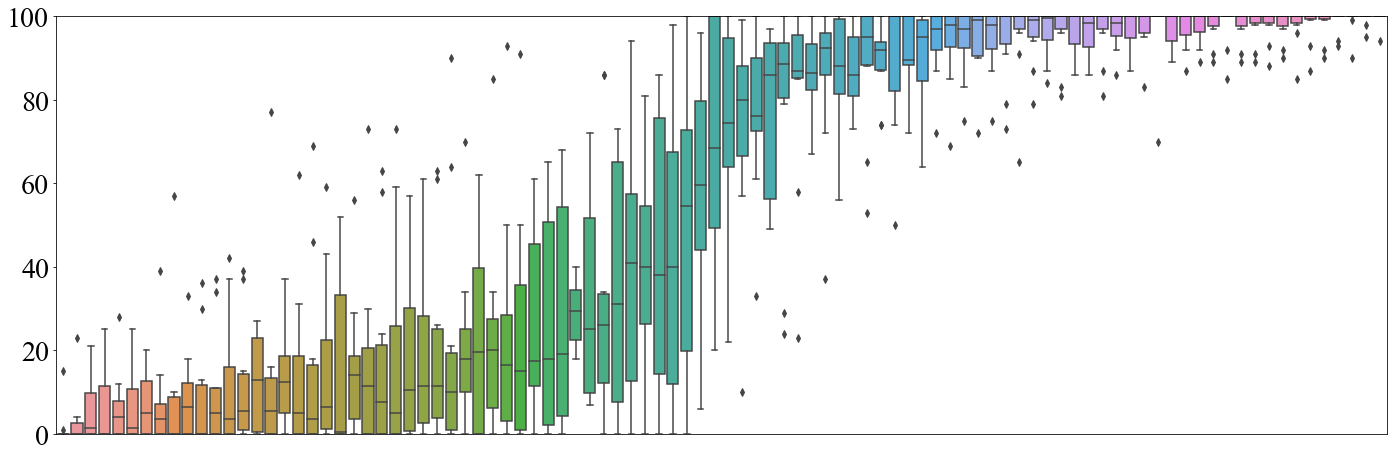

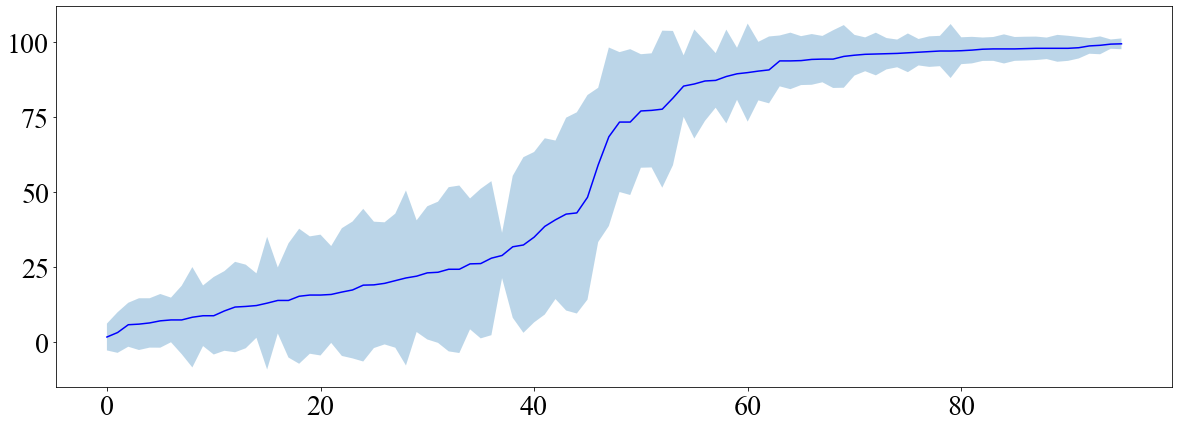

In [7]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

def plot(res_dict):
    colormap = cm.get_cmap("viridis", len(res_dict.keys()))
#     plt.figure()
    to_plot_xs = [i for i in range(len(res_dict.keys()))]
    to_plot_ys = []

    for i, (key, res_lines) in enumerate(res_dict.items()):
        ys = []
        for res_line in res_lines:
            ys.append(float(res_line["p_true"]))
            if res_line['dont_know'] == "0|1":
                color = "black"
            else:
                color = colormap(i)
#             plt.plot(i, float(res_line["p_true"]), ".", color = color)
#     plt.show()
        to_plot_ys.append(ys)
    return to_plot_xs, to_plot_ys
        
xs, ys = plot(by_sent_sorted_avg)
    
plt.figure(figsize=(20, 7))
ax = sns.boxplot(xs, ys)

ax.set_xticks([])
ax.set_ylim(0, 100)

# xs, ys = plot(by_sent_sorted_std_dev)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "ann_std_dev.png")) 

# data_frame = pd.DataFrame.from_records([[x] + y for x, y in zip(xs, ys)])
data_frame = pd.DataFrame.from_dict({x: pd.Series([x] + y + [np.mean(y)] + [np.std(y)])  for x, y in zip(xs, ys)})


data_frame = data_frame.T

data_frame.columns =  ['example'] + [f'anno_{i}' for i in range(0, 10)] + ['mean', "std_dev"]


plt.figure(figsize=(20, 7))
plt.plot(data_frame['example'], data_frame['mean'], "b-")
plt.fill_between(data_frame['example'], 
                 data_frame['mean'] - data_frame['std_dev'],
                 data_frame['mean'] +  data_frame['std_dev'],
                alpha = 0.3)




# ax = sns.lineplot(estimator = 'mean', data=data_frame, ci = "sd", err_style='band')

# ax.set_xticks([])
# ax.set_ylim(0, 100)

# xs, ys = plot(by_sent_sorted_std_dev)
# plt.savefig(os.path.join(figure_path, "ann_lineplot.png")) 


# plt.figure(figsize=(20, 10))
# sns.boxplot(xs, ys)

## conclusions 
annotations on some things are high-agreement, low std dev. In the middle there examples that annotators are uncertain on, with high std dev. So people sometimes disagree, often by one annotator who's an outlier. 

# correlation between human uncertainty (std-dev) and model uncertainty


In [8]:
import json
from glob import glob
import os 

all_dev_logits = {}
for path in glob("/Users/Elias/analytic_probing/logits/*.json"):
    model = os.path.basename(path).split(".")[0].split("_dev_logits")[0]
    with open(path) as f1:
        dev_logits = json.load(f1)
        all_dev_logits[model] = dev_logits

    
def log_softmax(lst):
    denom = 0
    to_ret = []
    for x in lst:
        exponent = np.exp(x)
        denom += exponent
        to_ret.append(exponent)
    return np.array(to_ret)/denom


for model, dev_logits in all_dev_logits.items():
    dev_data = {}
    for sent, logit in dev_logits.items():
        dev_data[sent] = log_softmax(logit)
    all_dev_logits[model] = dev_data
   
dev_data_sorted = sorted(dev_data.items(), key = lambda x: -  (x[1][0] * np.log(x[1][0]) + x[1][1] * np.log(x[1][1]) )  )
xs = [i for i in range(len(dev_data_sorted))]
ys = [data for key, data in dev_data_sorted]
# plt.plot(xs, ys, ".") 
    
    

model: bilinear_xlnet-base-cased, pearson rho 0.17894539154612726 p_value 0.0810820281152981
model: baseline_xlnet-base-cased, pearson rho 0.0783551358010769 p_value 0.28001187542720474
model: baseline_bert-base-cased, pearson rho 0.0683256660375252 p_value 0.2477492814244318
model: bilinear_bert-base-cased, pearson rho 0.05314117118692658 p_value 0.29894930340811593
model: bilinear_roberta-base, pearson rho 0.02128318246408076 p_value 0.641839726568338
model: baseline_roberta-base, pearson rho 0.04494485512003145 p_value 0.28153497932567356
model: sequence_roberta-base, pearson rho 0.06023764124458445 p_value 0.11874857141714748
model: sequence_xlnet-base-cased, pearson rho 0.04140601366569179 p_value 0.2517539405798358
model: sequence_bert-base-cased, pearson rho 0.032816742024637274 p_value 0.33530955894088893


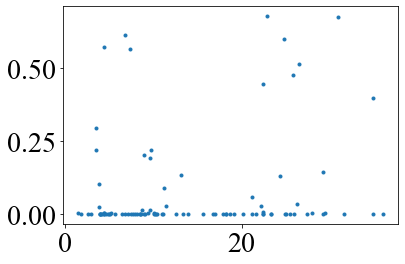

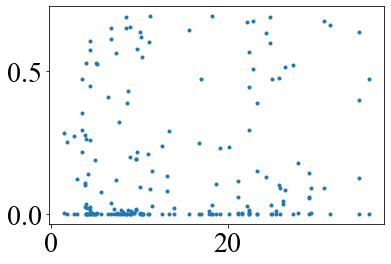

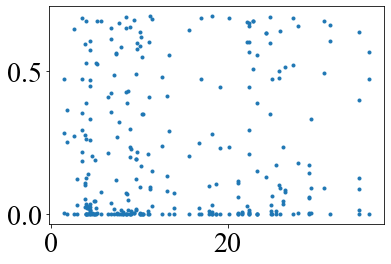

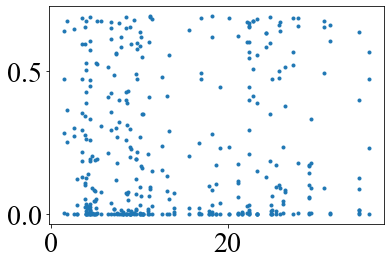

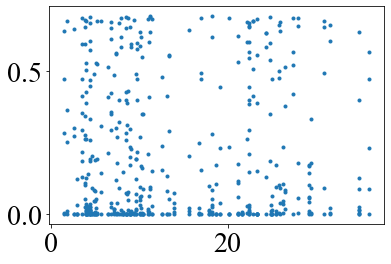

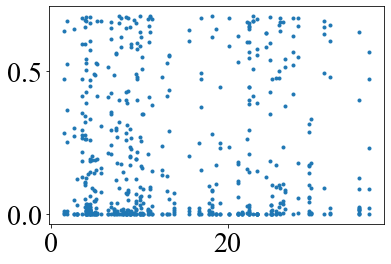

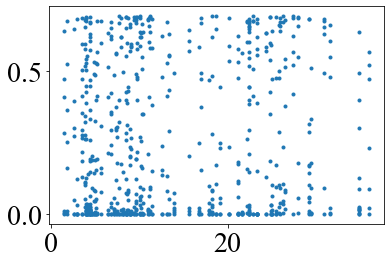

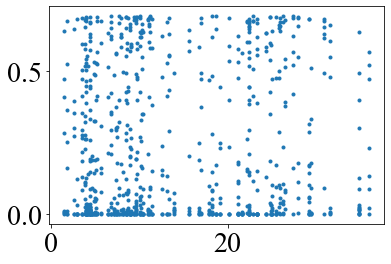

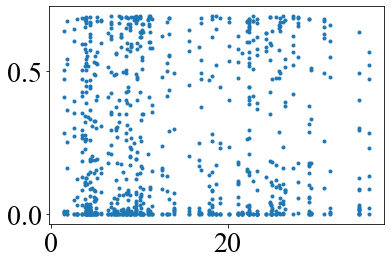

In [9]:
from scipy.stats import linregress, spearmanr, pearsonr

xs = []
ys = []

for model in all_dev_logits.keys():
    plt.figure()
    for sent, values in by_sent_sorted_std_dev.items():
        std_dev = np.std([x['p_true'] for x in values if x['dont_know'] != '0|1'])
        model_dist = np.array(all_dev_logits[model][sent])
        entropy = -np.sum(model_dist * np.log(model_dist))
        xs.append(std_dev)
        ys.append(entropy)

    plt.plot(xs, ys, ".")
# rho, p_value_spear = spearmanr(xs, ys)  
# print(f"spearman rho {rho} p_value {p_value_spear}")

    rho, p_value_spear = pearsonr(xs, ys)  
    print(f"model: {model}, pearson rho {rho} p_value {p_value_spear}")






## conclusions
- no significant correlation between annotator std dev. and entropy 
- so prima facie model uncertainty not correlated with annotator variance 

# correlation between "I don't know" and human uncertainty

pearson rho 0.49459356651040587 p_value 3.0245677145306057e-07


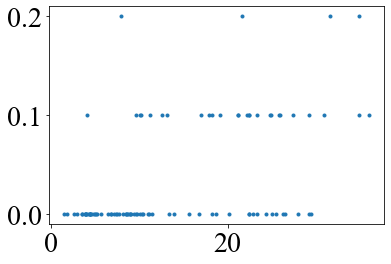

In [10]:
xs = []
ys = []


for sent, values in by_sent_sorted_std_dev.items():
    std_dev = np.std([x['p_true'] for x in values if x['dont_know'] != '0|1'])
#         model_dist = np.array(all_dev_logits[model][sent])
    p_dont_know = np.sum([1 if v['dont_know'] == "0|1" else 0 for v in values ])/len(values)
    xs.append(std_dev)
    ys.append(p_dont_know)

plt.plot(xs, ys, ".")

# rho, p_value_spear = spearmanr(xs, ys)  
# print(f"rho {rho} p_value {p_value_spear}")
rho, p_value_spear = pearsonr(xs, ys)  
print(f"pearson rho {rho} p_value {p_value_spear}")




## conclusions 
- significant correlation between std. dev. and probability that an annotator clicked "I don't know" 
- but obviously when people click "i don't know" they don't move the slider, so unsurprising that their guess would differ. 
    - I've removed "I don't know" annotations from values to account for this, the correlation remains 

# correlation between "I don't know" and model uncertainty

pearson rho -0.13817310911287847 p_value 0.1794243564057363


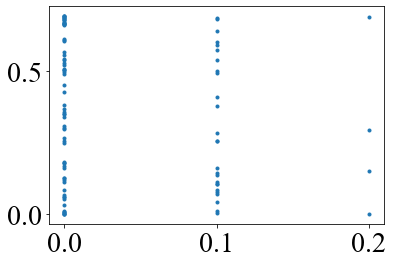

In [11]:
xs = []
ys = []

for sent, values in by_sent_sorted_std_dev.items():
#     std_dev = np.std([x['p_true'] for x in values])
    model_dist = np.array(dev_data[sent])
    entropy = -np.sum(model_dist * np.log(model_dist))

    p_dont_know = np.sum([1 if v['dont_know'] == "0|1" else 0 for v in values ])/len(values)
    xs.append(p_dont_know)
    ys.append(entropy)

plt.plot(xs, ys, ".")

# rho, p_value_spear = spearmanr(xs, ys)  
# print(f"rho {rho} p_value {p_value_spear}")
rho, p_value_spear = pearsonr(xs, ys)  
print(f"pearson rho {rho} p_value {p_value_spear}")




## conclusions
- no significant correlation between distribution entropy and an annotator clicking "I don't know" 

# correlation between human hedging (mean) and model uncertainty

model bilinear_xlnet-base-cased, pearson rho -0.17873871229610547 p_value 0.08143949246681992
model baseline_xlnet-base-cased, pearson rho 0.007584450185492808 p_value 0.9168452045655217
model baseline_bert-base-cased, pearson rho 0.019865836748565638 p_value 0.737096068979433
model bilinear_bert-base-cased, pearson rho 0.01947506448624786 p_value 0.7036309299219463
model bilinear_roberta-base, pearson rho 0.0308187659397052 p_value 0.5005625415614791
model baseline_roberta-base, pearson rho 0.012092975925971867 p_value 0.7721134375225469
model sequence_roberta-base, pearson rho -0.0010849531089018524 p_value 0.9776040510601778
model sequence_xlnet-base-cased, pearson rho 0.009971673383731904 p_value 0.7826249783708891
model sequence_bert-base-cased, pearson rho 0.02251277018990048 p_value 0.5086999587474814


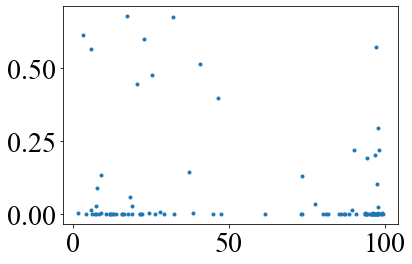

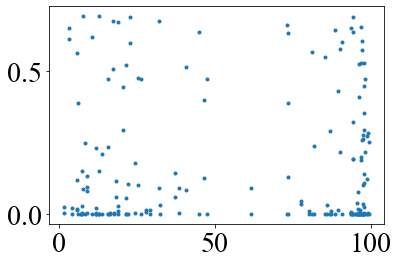

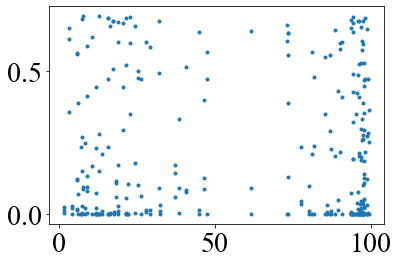

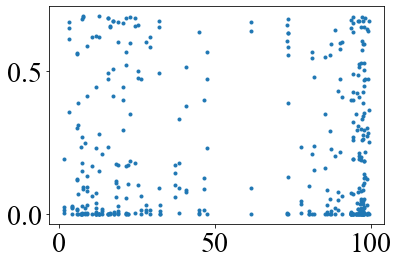

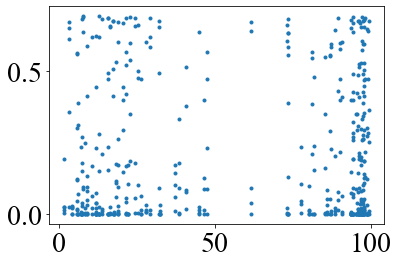

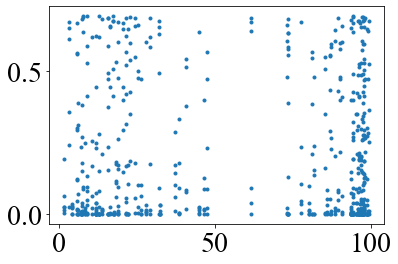

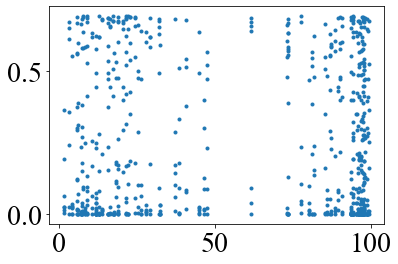

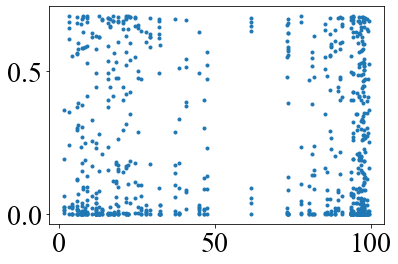

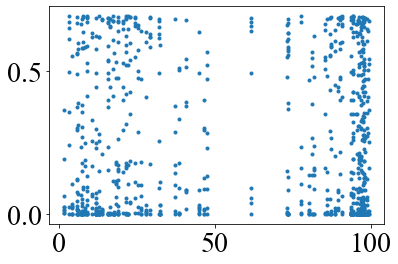

In [12]:
xs = []
ys = []

for model in all_dev_logits.keys():
    plt.figure()
    for sent, values in by_sent_sorted_avg.items():
        avg = np.mean([x['p_true'] for x in values if x['dont_know'] != '0|1'])
        model_dist = np.array(all_dev_logits[model][sent])
        entropy = -np.sum(model_dist * np.log(model_dist))

        xs.append(avg)
        ys.append(entropy)

    plt.plot(xs, ys, ".")

    # rho, p_value_spear = spearmanr(xs, ys)  
    # print(f"rho {rho} p_value {p_value_spear}")
    rho, p_value_spear = pearsonr(xs, ys)  
    print(f"model {model}, pearson rho {rho} p_value {p_value_spear}")


## conclusions
- no significant correlation between **average** annotator score and entropy 

# Correlation between all annotators and entropy

pearson rho 0.5527486911943948 p_value 8.44910775163943e-07
pearson rho 0.5126568282241724 p_value 1.088799870629433e-07
pearson rho 0.644295877153785 p_value 9.595380240807325e-06
pearson rho 0.5578841480892203 p_value 3.5279610148663648e-09
pearson rho 0.4446293009300153 p_value 5.667739815272358e-06
pearson rho 0.47889071797520166 p_value 0.00018870334160704484


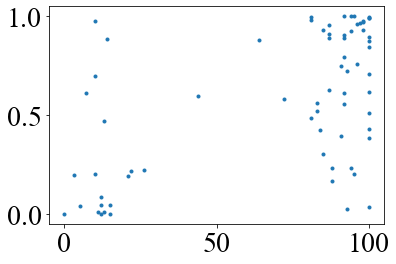

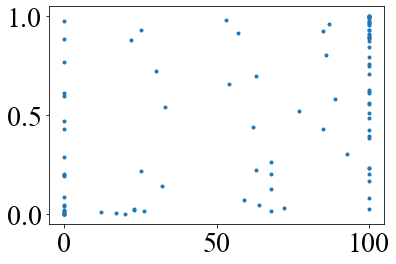

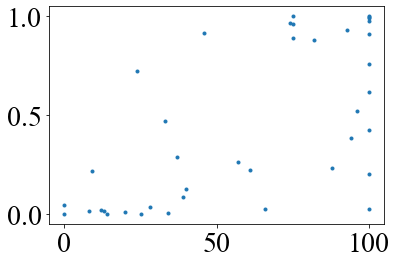

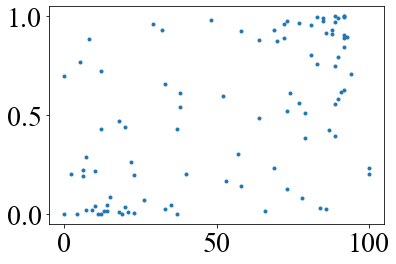

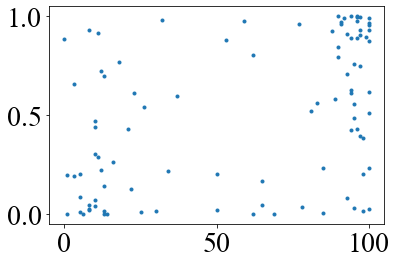

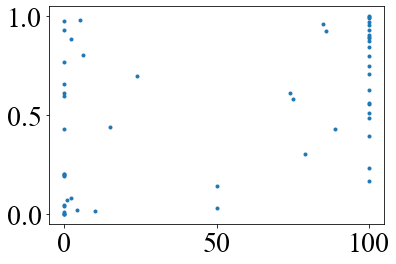

In [13]:
res_lines = parse_csv("/Users/Elias/Desktop/Batch_3845358_batch_results.csv")
by_annotator = group_by(res_lines, "worker_id")

for annotator in by_annotator.keys():
    
    xs = []
    ys = []

    for values in by_annotator[annotator]:
        
#         avg = np.mean([x['p_true'] for x in values if x['dont_know'] != '0|1'])
        if values['dont_know'] == '0|1':
            continue
        p_true = values['p_true']
        sent = values['sent']
        model_dist = np.array(dev_data[sent])
        p_true_model = model_dist[1]
#         entropy = -np.sum(model_dist * np.log(model_dist))

        xs.append(p_true)
        ys.append(p_true_model)
    plt.figure()
    plt.plot(xs, ys, ".")
   
    rho, p_value_spear = pearsonr(xs, ys)  
    print(f"pearson rho {rho} p_value {p_value_spear}")



## conclusions
- unsurprisingly, there's a correlation between model probability and human probability
- makes sense, they're doing the same task and the model does well 


# Correlation between model accuracy and human uncertainty 

In [14]:
from scipy.stats import f_oneway, kruskal


for model in all_dev_logits.keys():
    xs = []
    ys = []
    true_xs = []
    true_std_devs = []
    false_xs = []
    false_std_devs = []
    
    for i, (sent, values) in enumerate(by_sent_sorted_std_dev.items()):
        std_dev = np.std([x['p_true'] for x in values if x['dont_know'] != '0|1'])
        label = values[0]['label']

        model_dist = np.array(all_dev_logits[model][sent])
#         if sent == "an exit is an opening that permits escape or release":
#             print(model, model_dist)
    #     print(model_dist)
        pred = np.argmax(model_dist) 
        # add in the uncertainty
    #     pred *= model_dist[pred]
        true = 1 if label == "True" else 0
        if pred == true:
            true_std_devs.append(std_dev)
            true_xs.append(i)
    #         print("correct")
    #         print(sent)
    #         print(label)
    #         print(pred)
    # #         sys.exit()
        else:
            false_std_devs.append(std_dev)
            false_xs.append(i)
    #         print("incorrect")
    #         print(sent)
    #         print(label)
    #         print(pred)
    #         sys.exit()

        entropy = -np.sum(model_dist * np.log(model_dist))

        xs.append(std_dev)
        ys.append(pred)

#     sns.distplot(true_std_devs)
#     plt.figure()
#     sns.distplot(false_std_devs)
#     plt.figure()

#     stat, p_value = f_oneway(true_std_devs, false_std_devs)
#     print(f"anova f_val {stat} p_value {p_value}")
    stat, p_value = kruskal(true_std_devs, false_std_devs)
    print(f"model {model} kruskal f_val {stat} p_value {p_value}")

    print(f"mean std dev for true {np.mean(true_std_devs)}")
    print(f"mean std dev for false {np.mean(false_std_devs)}")

model bilinear_xlnet-base-cased kruskal f_val 3.382886348159814 p_value 0.06587659367796676
mean std dev for true 12.851922242713776
mean std dev for false 17.132945052272483
model baseline_xlnet-base-cased kruskal f_val 2.269905112013932 p_value 0.13190797834350043
mean std dev for true 13.435419032151765
mean std dev for false 16.842117516709546
model baseline_bert-base-cased kruskal f_val 0.5319264232916723 p_value 0.46579807533155715
mean std dev for true 13.67845309413595
mean std dev for false 15.337812343790539
model bilinear_bert-base-cased kruskal f_val 2.835467201433696 p_value 0.09220398140157932
mean std dev for true 13.287094501205758
mean std dev for false 15.575236852927212
model bilinear_roberta-base kruskal f_val 0.5465153553057958 p_value 0.4597450240505776
mean std dev for true 13.51520898618016
mean std dev for false 15.29385998925162
model baseline_roberta-base kruskal f_val 0.05569649503134583 p_value 0.8134318563411344
mean std dev for true 14.255587158312263
mea

## conclusions
- the standard deviations of human annotators on prompts the model got wrong are significantly different from the std devs for prompts the model got right 

# Explore qualitative differences

In [15]:
def pprint(item):
    key, values = item
    p_trues = [v['p_true'] for v in values]
    print(f"{key}: {p_trues}, {np.std(p_trues)}")
    print(f"\t{dev_data[key]}")

for i in [-9, -5, -4, -3, -2, -1]:
    pprint(list(by_sent_sorted_std_dev.items())[i])

a coat is an archaic term for clothing: [7.0, 0.0, 23.0, 0.0, 38.0, 91.0, 50.0, 0.0, 29.0, 4.0], 27.934924377918044
	[0.39029855 0.60970145]
a separation is an abstraction belonging to or characteristic of two entities or parts together: [0.0, 50.0, 40.0, 68.0, 10.0, 0.0, 42.0, 60.0, 94.0, 21.0], 29.3981291921782
	[0.79570439 0.20429561]
a transit is a surveying instrument for measuring horizontal and vertical angles, consisting of a small telescope mounted on a tripod: [78.0, 28.0, 49.0, 100.0, 20.0, 100.0, 100.0, 59.0, 100.0, 50.0], 29.77314225942569
	[0.96500084 0.03499916]
Congress is a gathering of the minimal number of members of an organization to conduct business: [46.0, 30.0, 11.0, 86.0, 57.0, 82.0, 0.0, 86.0, 4.0, 24.0], 32.1658203688325
	[0.08614913 0.91385087]
wheat is narrow-leaved green herbage: grown as lawns; used as pasture for grazing animals; cut and dried as hay: [68.0, 25.0, 66.0, 10.0, 98.0, 18.0, 55.0, 84.0, 6.0, 0.0], 33.555923471125034
	[0.98397094 0.01602906]


## single-column figure

Version 1: two figures on shared axis showing the model is very different from graded human response 

Version 2: one figure with graded human response, but color as xlnet prediction

dict_keys(['bilinear_xlnet-base-cased', 'baseline_xlnet-base-cased', 'baseline_bert-base-cased', 'bilinear_bert-base-cased', 'bilinear_roberta-base', 'baseline_roberta-base', 'sequence_roberta-base', 'sequence_xlnet-base-cased', 'sequence_bert-base-cased'])


<Figure size 432x288 with 0 Axes>

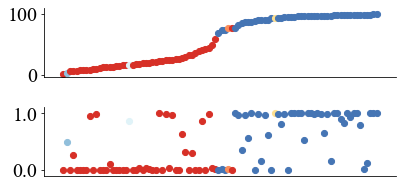

In [16]:
import os
from analysis import parse_csv
from collections import defaultdict, OrderedDict 
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

def group_by(res_lines, variable_name):
    to_ret = defaultdict(list)
    for line in res_lines:
        interest_key = line[variable_name]
        to_ret[interest_key].append(line)
        
    return to_ret

def sort_by_fxn(res_dict, fxn):
    new_dict = OrderedDict()
#     average = lambda x: sum(x)/len(x)
    to_sort = []
    for key, values in res_dict.items():
        ps = [line['p_true'] for line in values]
        score = fxn(ps)
        to_sort.append((score, key, values))
    to_sort = sorted(to_sort, key = lambda x: x[0])
    
    for __, key, values in to_sort:
        new_dict[key] = values
    return new_dict

res_lines = parse_csv("/Users/Elias/Desktop/all_10.csv")
figure_path = "/Users/Elias/analytic-acl-2020/figures/"

by_sent = group_by(res_lines, "sent")
by_sent_sorted_avg = sort_by_fxn(by_sent, lambda x: np.mean(x))
by_sent_sorted_std_dev = sort_by_fxn(by_sent, lambda x: np.std(x))

xs = np.arange(len(by_sent_sorted_avg.keys()))
human_ys = [np.mean([line['p_true']  for line in by_sent_sorted_avg[key] ] ) for key in by_sent_sorted_avg.keys() ]
sents = [line[0]['sent'] for line in by_sent_sorted_avg.values()]

true_colors = [lines[0]['label'] for lines in by_sent_sorted_avg.values() ]
print(all_dev_logits.keys())
model_preds = all_dev_logits['sequence_xlnet-base-cased']
model_ys = [model_preds[sent][1] for sent in by_sent_sorted_avg.keys()]


# palette = {"True": "#91bfdb" ,
#            "False": "#fc8d59",
#           "tshirt1": ,
#           "tshirt2": ,
#            "journalism": ,
#            "teammate":           }

palette = {"True": '#4575b4' ,
           "False": '#d73027',
          "tshirt1": '#e0f3f8',
          "tshirt2": '#fee090',
           "journalism": '#fc8d59',
           "teammate": '#91bfdb'}

markers = {"True": "." ,
           "False": "."}


sentences_of_interest = {'T-shirt is an archaic term for clothing': "tshirt1", 
                         'journalism is newspapers and magazines collectively': "journalism",
                        'T-shirt is a close-fitting pullover shirt':"tshirt2", 
                         'a teammate is someone who is under suspicion':"teammate"}


# VERSION 1
plt.figure()
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(6,3))
for x, y, c, s in zip(xs, human_ys, true_colors, sents):
    color =c 
    if s in sentences_of_interest.keys():
        color =  sentences_of_interest[s]
    
    axs[0].scatter([x], [y], s = 150, marker = markers[c], color = palette[color])

for x, y, c, s in zip(xs, model_ys, true_colors, sents):
    color=c
    if s in sentences_of_interest.keys():
        color =  sentences_of_interest[s]
    axs[1].scatter([x], [y], s = 150, marker = markers[c], color = palette[color])  

axs[1].set_yticks([0.0, 1.0])
axs[1].set_yticklabels([0.0, 1.0])
for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
#     axs[i].spines['bottom'].set_visible(False)
#     axs[i].spines['left'].set_visible(False)
# axs[0].spines['bottom'].set_visible(True)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "scores_version_1.pdf")) 
# VERSION 2
if False:




    plt.figure()
    fig, axs = plt.subplots(1, 1, sharex='col', figsize=(8, 3))
    model_colors = ["True" if y > 0.50 else "False" for y in model_ys ]

    for x, y, c in zip(xs, human_ys, model_colors):
        axs.scatter([x], [y], s = 150, marker = markers[c], color = palette[c])

    axs.set_xticks([])
    axs.set_xticklabels([])
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    # axs.spines['bottom'].set_visible(False)
    # axs.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(figure_path, "scores_version_2.pdf")) 

    # plt.fill_between(data_frame['example'], 
    #                  data_frame['mean'] - data_frame['std_dev'],
    #                  data_frame['mean'] +  data_frame['std_dev'],
    #                 alpha = 0.3)





a separation is the state of lacking unity
True
